In [1]:
import os

os.chdir('../..')
!pwd

/Users/adamswietek/Documents/PostDoc/HiddenHousing


In [2]:
from src.geoadmin import load_cities

la = load_cities().query('CITYNAME_ALF == "LOS ANGELES"').to_crs(4326)

In [2]:
'''load parcels from udu dataset'''
from src.constants import BBOX, WGS84_EPSG  
from src.geoadmin import load_parcels_by_AIN

import pandas as pd

udu_df = pd.read_csv('data/01_raw/UDU Report 25.12.16.csv')

#manual filter and stringify for sql search
reject_ain = ['2654021BRK']
l = (udu_df[udu_df['assessor_parcel_number'] != '2654021BRK']
     .assessor_parcel_number
     .astype(str)
     .unique()
     .tolist()
     )

parcels = load_parcels_by_AIN(l)
parcels.shape

(2921, 51)

In [5]:
parcels.to_csv('data/udu_parcels.csv')

In [3]:
parcels['RollYear'].value_counts().sort_index()

RollYear
2006    180
2007    181
2008    181
2009    182
2010    182
2011    183
2012    183
2013    183
2014    183
2015    183
2016    183
2017    183
2018    183
2019    183
2020    184
2021    184
Name: count, dtype: int64

In [5]:
''' change in values across the years '''
# Sort so shift() compares prior year
udu_sorted = parcels.sort_values(["AIN", "RollYear"])

value_cols = [c for c in udu_sorted.columns if c not in ["AIN", "RollYear","ZIPcode","Location 1","CENTER_LON"]]

def change_rows(col):
    # True where the value changed vs. previous year (first row per AIN is treated as change; drop .fillna(True) to keep it)
    changed = udu_sorted.groupby("AIN")[col].transform(lambda s: s.ne(s.shift()).fillna(False))
    return (
        udu_sorted.loc[changed, ["AIN", "RollYear", col]]
        .rename(columns={col: "value"})
        .assign(column=col)
    )

change_years = pd.concat([change_rows(c) for c in value_cols], ignore_index=True)

# Example outputs:
# change_years  -> rows: AIN, RollYear, column, value where a change occurred
# earliest change per AIN/column:
# change_years.groupby(["AIN", "column"])["RollYear"].min()


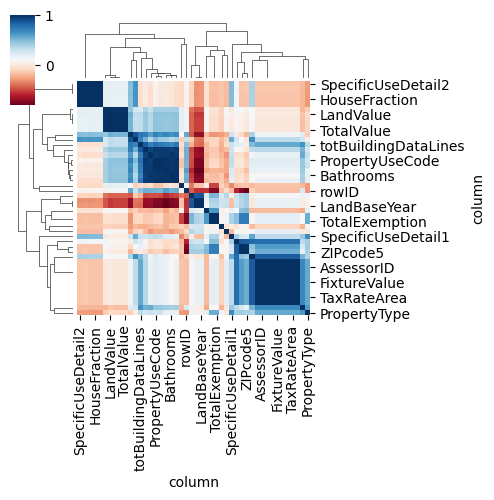

In [9]:
import seaborn as sns

Z = pd.crosstab(change_years['RollYear'], change_years['column']).iloc[1:,:].T
corr = Z.T.corr()
sns.clustermap(corr, figsize=(5,5), cmap = 'RdBu')

In [ ]:
change_years.query('column == SQFTmain').groupby(['AIN'])['']

column
LandBaseYear                  -0.698268
ImpBaseYear                   -0.675537
RecordingDate                 -0.485544
Cluster                       -0.222697
YearBuilt                     -0.179024
PersonalPropertyValue         -0.174594
HomeownersExemption           -0.141116
TotalExemption                -0.141116
CENTER_LAT                    -0.096805
ZIPcode5                      -0.035572
StreetDirection                0.018159
HouseFraction                  0.019704
SpecialParcelClassification    0.019704
UnitNo                         0.023492
SpecificUseDetail2             0.033271
PropertyLocation               0.073160
StreetName                     0.085137
PropertyType                   0.260125
SpecificUseDetail1             0.290369
City                           0.338819
TaxRateArea                    0.349895
isTaxableParcel?               0.349895
TaxRateArea_CITY               0.349895
HouseNo                        0.349895
PersonalPropertyExemption      0.

In [14]:
change_years

,AIN,RollYear,value,column
0,2102021039,2006,LOS ANGELES,TaxRateArea_CITY
1,2162007069,2006,LOS ANGELES,TaxRateArea_CITY
2,2209005026,2006,LOS ANGELES,TaxRateArea_CITY
3,2219016039,2006,LOS ANGELES,TaxRateArea_CITY
4,2224005030,2006,LOS ANGELES,TaxRateArea_CITY
...,...,...,...,...
27541,7458014022,2018,33.733874,CENTER_LAT
27542,7458025016,2006,33.729059,CENTER_LAT
27543,7458025016,2018,33.729064,CENTER_LAT
27544,7462021012,2006,33.725821,CENTER_LAT


In [ ]:
(change_years
 .query('column == "SQFTmain"')
 .groupby('AIN')['RollYear']
 .diff()
)

2784     NaN
2785     NaN
2786     NaN
2787     NaN
2788     NaN
        ... 
3014     NaN
3015     NaN
3016     NaN
3017     NaN
3018    15.0
Name: RollYear, Length: 235, dtype: float64